playground-series-s5e12.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  playground-series-s5e12.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
Data downloaded and unzipped successfully.
Train Shape: (700000, 26)
Test Shape: (300000, 25)
Target Column identified: diagnosed_diabetes


/tmp/ipython-input-770947881.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train[target_col], palette='viridis')


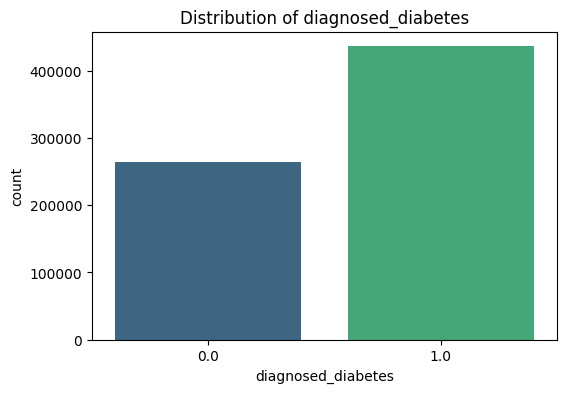

Total Missing Values in Train: 0


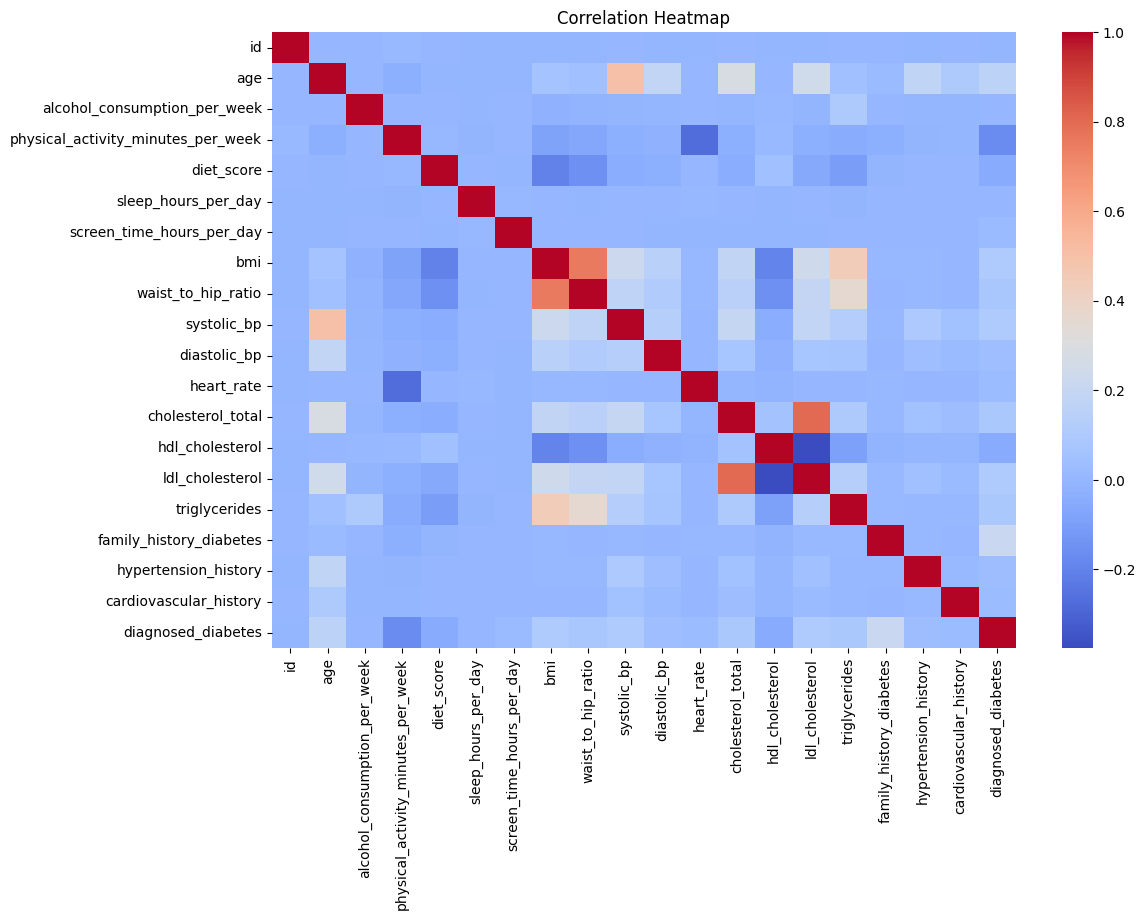

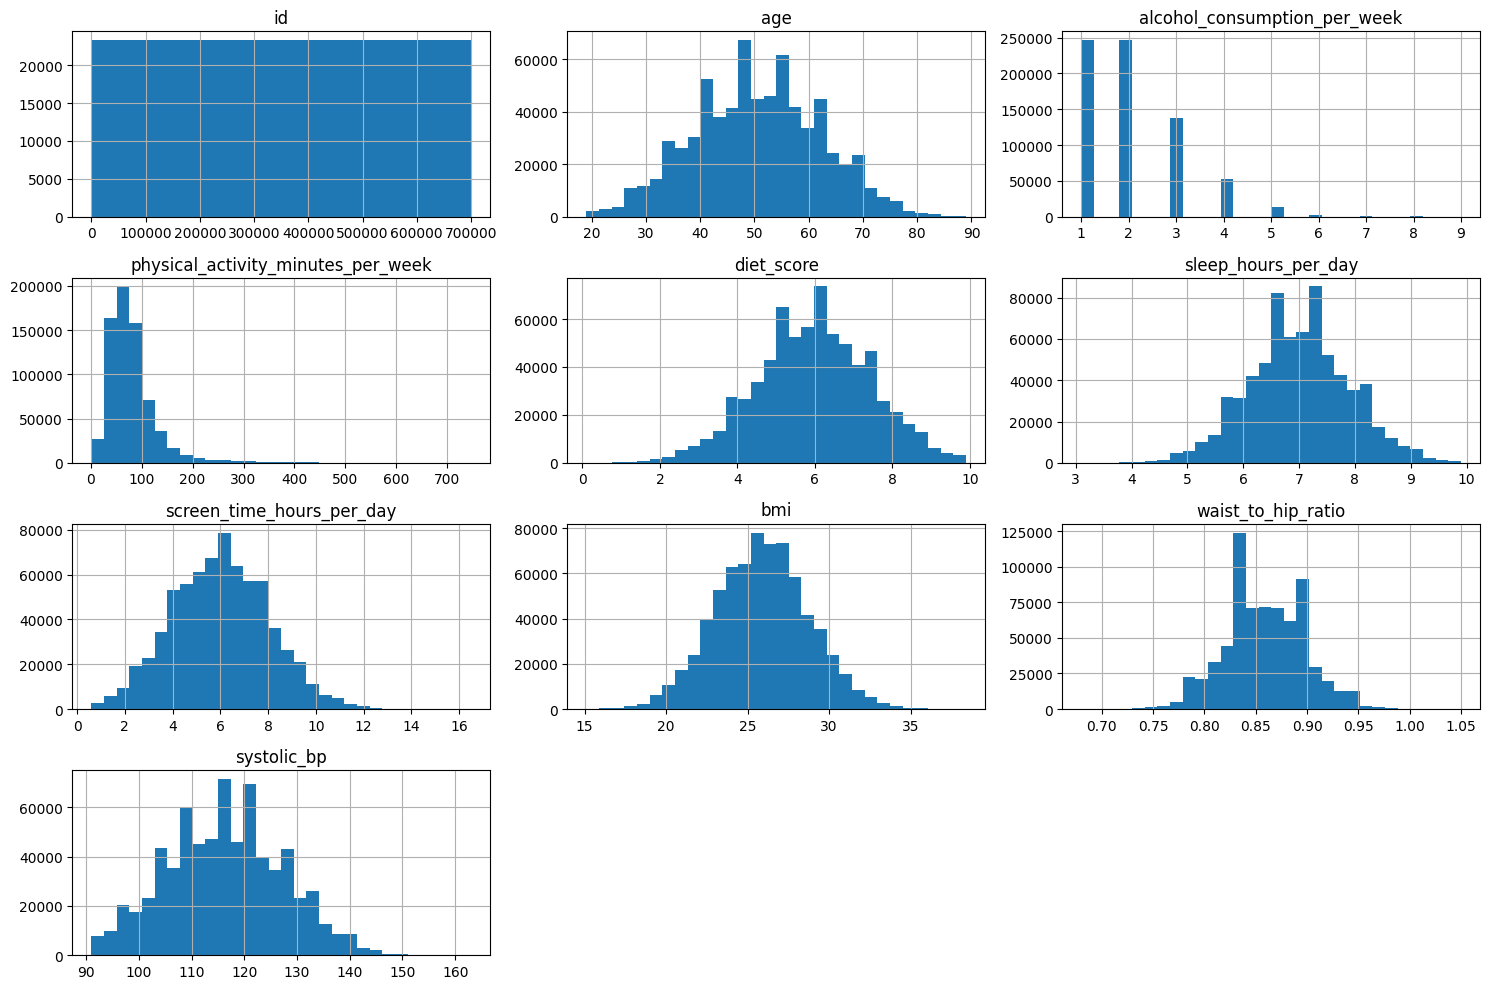

Categorical columns: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
Numerical columns: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
Logistic Regression AUC: 0.69463
Random Forest AUC: 0.69830
XGBoost Baseline AUC: 0.72519


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import xgboost as xgb # Import xgboost for callbacks

# --- STEP 1: UPLOAD KAGGLE.JSON ---
# You will be prompted to upload your kaggle.json file here.
if not os.path.exists("/root/.kaggle/kaggle.json"):
    print("Please upload your kaggle.json file.")
    uploaded = files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/.kaggle.json
    print("Kaggle API token configured.")

# --- STEP 2: DOWNLOAD DATA ---
COMPETITION_NAME = "playground-series-s5e12"

!kaggle competitions download -c {COMPETITION_NAME}
!unzip -o {COMPETITION_NAME}.zip
print("Data downloaded and unzipped successfully.")
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

# Display basic info
print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

# Identify Target Column (Usually named 'target' or similar in Playground Series)
# We will check the columns to confirm
target_col = [col for col in train.columns if col not in test.columns][0]
print(f"Target Column identified: {target_col}")

train.head()
# 1. Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=train[target_col], palette='viridis')
plt.title(f'Distribution of {target_col}')
plt.show()

# 2. Missing Value Analysis
missing_values = train.isnull().sum().sum()
print(f"Total Missing Values in Train: {missing_values}")

# 3. Correlation Heatmap (Numerical Features Only)
plt.figure(figsize=(12, 8))
numeric_cols = train.select_dtypes(include=[np.number]).columns
sns.heatmap(train[numeric_cols].corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# 4. Feature Histograms (Sample of first 10 numerical features)
train[numeric_cols[:10]].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Drop ID
train_id = train['id']
test_id = test['id']
X = train.drop(['id', target_col], axis=1)
y = train[target_col]
X_test = test.drop(['id'], axis=1)

# Handle Categorical Features
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns: {cat_cols}")
print(f"Numerical columns: {num_cols}")

# Simple Label Encoding for categorical data
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

# Scaling numerical data
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Define early stopping callback (Removed as 'callbacks' argument is not supported in the current XGBoost version's fit method)
# early_stopping_callback = xgb.callback.EarlyStopping(rounds=50, min_delta=1e-5,  save_best=True)

# 1. Logistic Regression Baseline
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict_proba(X_val)[:, 1]
print(f"Logistic Regression AUC: {roc_auc_score(y_val, lr_preds):.5f}")

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict_proba(X_val)[:, 1]
print(f"Random Forest AUC: {roc_auc_score(y_val, rf_preds):.5f}")

# 3. XGBoost Baseline
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=6, tree_method='gpu_hist' if os.path.exists('/proc/driver/nvidia') else 'auto')
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
xgb_preds = xgb_model.predict_proba(X_val)[:, 1]
print(f"XGBoost Baseline AUC: {roc_auc_score(y_val, xgb_preds):.5f}")

### Generate Submission File

Using the best-performing XGBoost model, we'll predict the probabilities on the unseen test dataset (`X_test`). These predictions will then be formatted into a `submission.csv` file, following the Kaggle competition's required structure (`id`, `diagnosed_diabetes`).

In [5]:
# Predict probabilities on the test set using the best model (XGBoost)
xgb_test_preds = xgb_model.predict_proba(X_test)[:, 1]

# Create a submission DataFrame
submission = pd.DataFrame({'id': test_id, target_col: xgb_test_preds})

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' generated successfully.")

# Display the first few rows of the submission file
display(submission.head())

Submission file 'submission.csv' generated successfully.


,id,diagnosed_diabetes
0,700000,0.465270
1,700001,0.660675
2,700002,0.780457
3,700003,0.401435
4,700004,0.931983


### Submit to Kaggle

To submit the `submission.csv` file to the Kaggle competition, we'll use the Kaggle API command `kaggle competitions submit`. You'll need to provide a message for your submission.

In [7]:
# Submit the submission.csv file to the competition
!kaggle competitions submit -c {COMPETITION_NAME} -f submission.csv -m "XGBoost baseline submission"

100% 4.99M/4.99M [00:00<00:00, 12.2MB/s]
Successfully submitted to Diabetes Prediction Challenge